# BASIC CONFIGURATIONS

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
# If crashes, make sure the deve is correct.
root =  devBoard.Root(   
        top_level  = top_level,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        pciePgpEn  = True,
        justCtrl   = False,
        DDebugSize = 4000)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
Root.pciePgp.AxiPcieCore.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000400
UpTime       = 3 days, 12:48:08
GitHash      = 0xff123dbf47e096d5f874dd9b3e9a5909aebee138
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = "ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Sat 23 Mar 2024 06:19:41 AM PDT
Builder      = dnajjar"
###################################################


In [3]:
#Run this from a teminal in your localhost without the (!). If you run it here, it will open on rdsrv314 Jupyter server terminal and you won't see it.
#!python -m pyrogue gui --server='rdsrv314:9099'

In [4]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG = [None] * 4
PKREG[0] = ASICTOP.DigAsicStrmRegisters0
PKREG[1] = ASICTOP.DigAsicStrmRegisters1
PKREG[2] = ASICTOP.DigAsicStrmRegisters2
PKREG[3] = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [5]:
# Set & Read ScratchPad
print(hex(AXIV.ScratchPad.get()))
AXIV.ScratchPad.set(0xdeadbeef)
print(hex(AXIV.ScratchPad.get()))

0xdeadbeef
0xdeadbeef


In [6]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_75000018efb4ab01_SspMonGrp_carrier.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_RegisterControl.yml
Loading batcher configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_BatcherEventBuilder.yml
Loading packet register configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320

# Disable full rate receivers for now

In [7]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

In [8]:
#get locked lanes
root.getLaneLocks()

ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xffffff


# Clear PGP and DigAsicStrmReg counters

In [19]:
def clearPpg():
    for i in range(4):
        root.pciePgp.Lane[i].Ctrl.CountReset()

def clearDigAsicStrmReg():
    for i in range(4):
        PKREG[i].CountReset()


def disablePpgFlowCtrl(disable):
    for i in range(4):
        root.pciePgp.Lane[i].Ctrl.FlowControlDisable.set(disable)

def getPKREGCounters() :
    for i in range(4):
        print("DigAsicStrmRegister{} count={}".format(i, PKREG[i].FrameCount.get()))
    

In [13]:
clearPpg()
clearDigAsicStrmReg()
disablePpgFlowCtrl(False)

# Release a number of frames on max rate

In [6]:
ssdPath = "/u1/ePixHRM320k/acquisition"
filename = f"{ssdPath}/maxRate14.dat"

In [7]:
root.enableAllAsics(True)
#root.enableDataDebug(True)
DEBUG0.cleanData()
DEBUG1.cleanData()
DEBUG2.cleanData()
DEBUG3.cleanData()

frames = 100
rate = 5000

#root.hwTrigger(frames, rate)
root.acquireToFile(filename, frames, rate)

Acquisition started: filename: /u1/ePixHRM320k/acquisition/maxRate14.dat, rate: 5000, #frames:100
Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed
Received on channel 0 100 frames...
Received on channel 1 100 frames...
Received on channel 2 100 frames...
Received on channel 3 100 frames...
Waiting for file to close...
Acquisition complete and file closed


# Examine pgpcard and DigAsicStrmReg

In [11]:
def getPgpFrmCnt():
    frmCnt = [None] * 4
    for i in range(4):
        frmCnt[i] = root.pciePgp.Lane[i].RxStatus.FrameCnt.get()
    return frmCnt

def getDigAsicStrmRegFrmCnt():
    frmCnt = [None] * 4
    for i in range(4): 
        frmCnt[i] = PKREG[i].FrameCount.get()
    return frmCnt

In [12]:
digAsicStrmRegFrmCnt = getDigAsicStrmRegFrmCnt()
print("Firmware counted {}".format(digAsicStrmRegFrmCnt))
pgpFrmCnt = getPgpFrmCnt()
print("Pgpcard counted {}".format(pgpFrmCnt))

Firmware counted [0, 0, 0, 0]
Pgpcard counted [0, 0, 0, 0]


In [10]:
root.readFromFile(filename)

In [15]:
for i in range(4): 
    print("readerReceiver[{}] has {}".format(i, np.shape(root.readerReceiver[i].getData()))

SyntaxError: unexpected EOF while parsing (37367402.py, line 2)

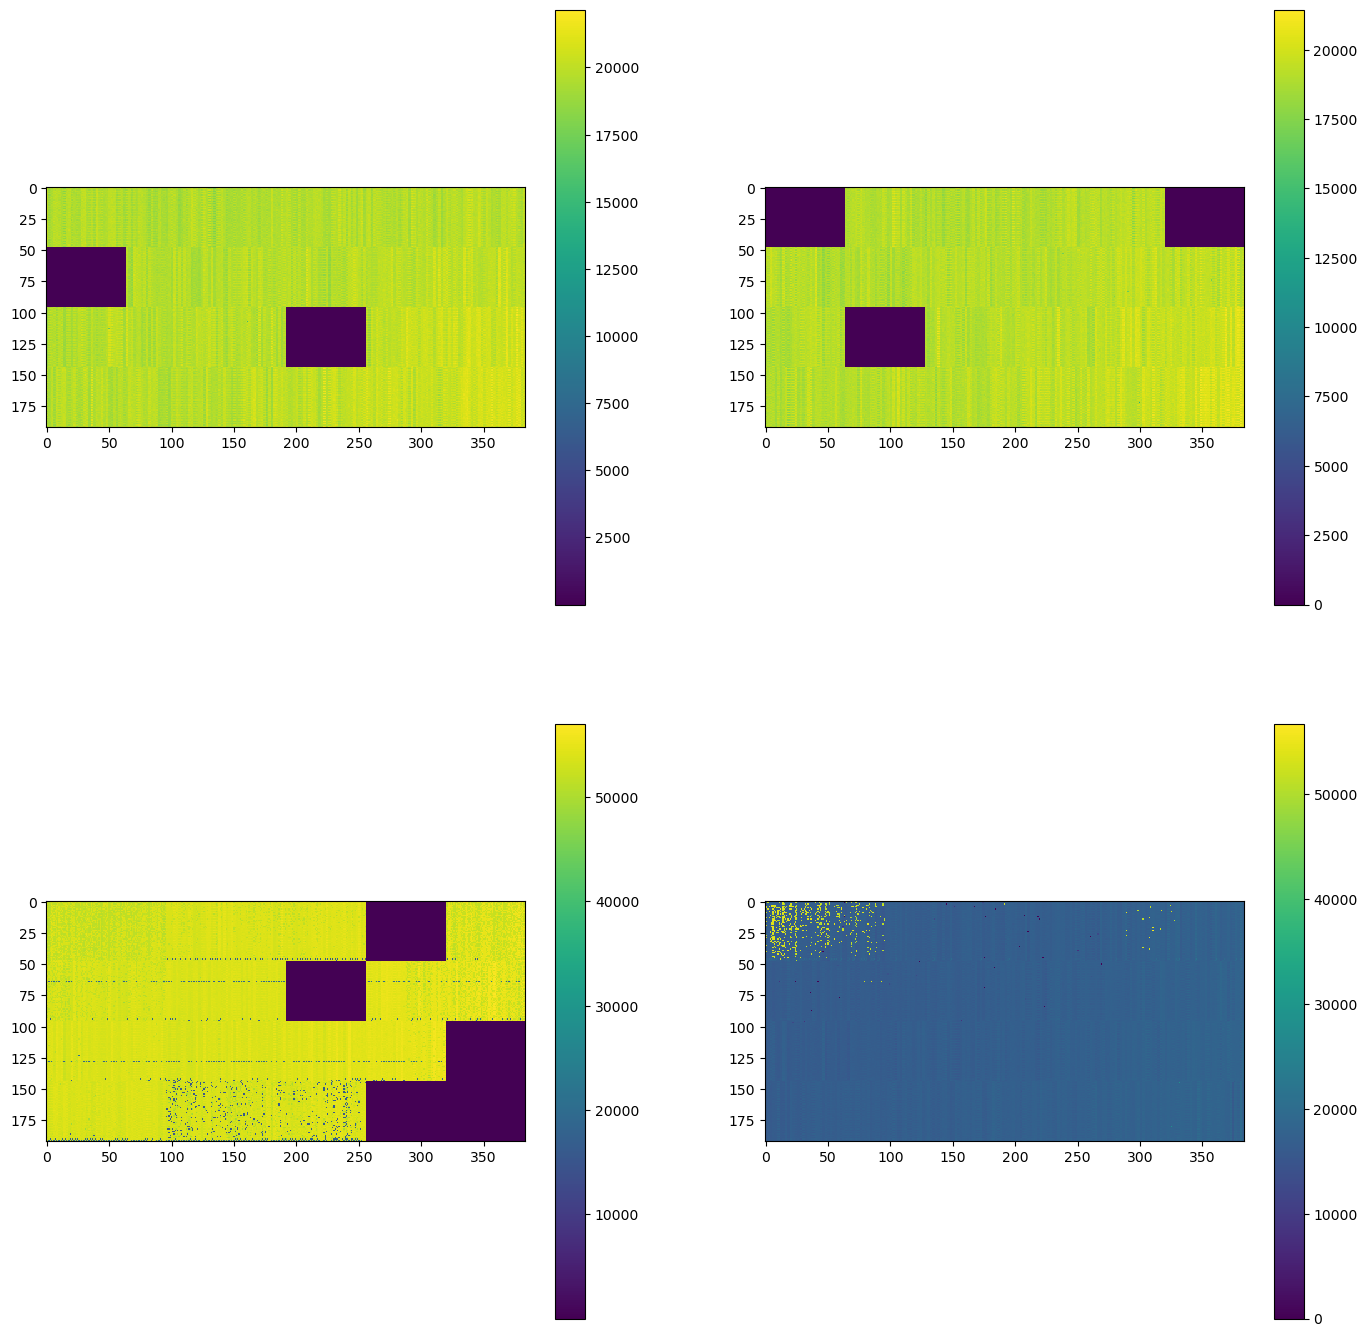

In [20]:
plt.subplots(2,2,figsize=(17,17))
for imageIndex in range(4):
    plt.subplot(2,2,imageIndex+1)
     
    plt.imshow(root.readerReceiver[imageIndex].getData()[:,:,0], interpolation='nearest')
    #plt.xlabel("ASIC {} frame 0".format(imageIndex))
    plt.colorbar()

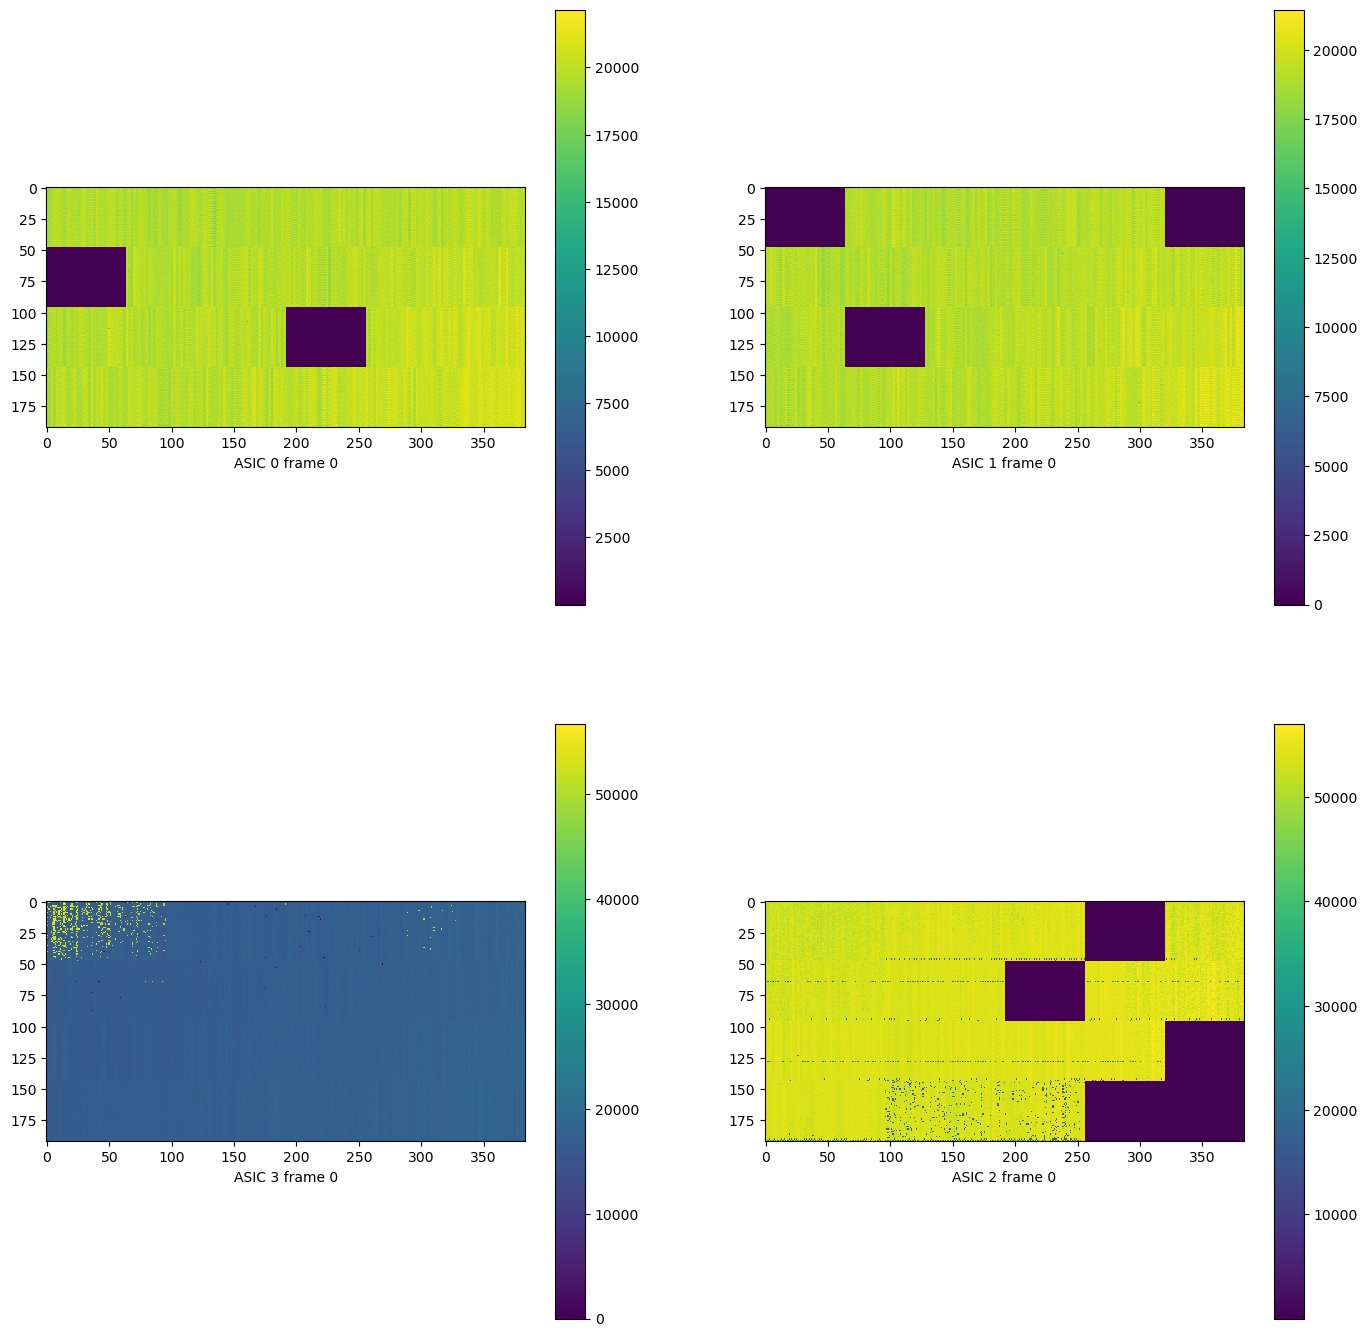

In [7]:
plt.subplots(2,2,figsize=(17,17))

plt.subplot(2,2,1)
plt.imshow(DEBUG0.getData()[:,:,0], interpolation='nearest')
plt.xlabel("ASIC 0 frame 0")
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(DEBUG1.getData()[:,:,0], interpolation='nearest')
plt.xlabel("ASIC 1 frame 0")
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(DEBUG2.getData()[:,:,0], interpolation='nearest')
plt.xlabel("ASIC 2 frame 0")
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(DEBUG3.getData()[:,:,0], interpolation='nearest')
plt.xlabel("ASIC 3 frame 0")
plt.colorbar()


# Test with flow control enabled & disabled

In [7]:
def clearUpStreamPpg():
    for i in range(4):
        root.pciePgp.Lane[i].Ctrl.CountReset()

def clearDownStreamPpg():
    for i in range(4):
        root.Core.PgpMon[i].Ctrl.CountReset()

def getUpStreamPpgFrmCnt():
    for i in range(4):
        print("Upstream pgp got {} frames".format(root.pciePgp.Lane[i].RxStatus.FrameCnt.get()))

def getDownStreamPpgFrmCnt():
    for i in range(4):
        print("Downstream pgp got {} frames".format(root.Core.PgpMon[i].TxStatus.FrameCnt.get()))
        
def clearDigAsicStrmReg():
    for i in range(4):
        PKREG[i].CountReset()

def clearSspMonGrp() :
    for i in range(4):
        root.App.SspMonGrp[i].CntRst()

def disablePpgFlowCtrl(disable):
    for i in range(4):
        root.pciePgp.Lane[i].Ctrl.FlowControlDisable.set(disable)

def getPKREGCounters() :
    TimeoutCntLane = [0] * 24
    LockedCnt      = [0] * 24
    BitSlipCnt     = [0] * 24
    ErrorDetCnt    = [0] * 24
    DataOvfLane    = [0] * 24    
    threshold = 1
    for asicIndex in range(4):
        disable = getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()
        print("DigAsicStrmRegister{} FrameCount={} disable={}".format(asicIndex, PKREG[asicIndex].FrameCount.get(), hex(disable)))
        for i in range(24):
            if ((0x1 << i) & disable) != 0 :
                continue
            TimeoutCntLane[i] = getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").TimeoutCntLane[i].get()
            if(TimeoutCntLane[i]> threshold) :
                print("ASIC {} Lane {} is having {} timeouts".format(asicIndex, i, TimeoutCntLane[i]))

            DataOvfLane[i] = getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DataOvfLane[i].get()
            if(DataOvfLane[i]> 0) :
                print("ASIC {} Lane {} is having overflow of {}".format(asicIndex, i, DataOvfLane[i]))

            LockedCnt[i] = getattr(root.App, f"SspMonGrp[{asicIndex}]").LockedCnt[i].get()
            if(LockedCnt[i]> threshold) :
                print("ASIC {} Lane {} is having {} locked Counts".format(asicIndex, i, LockedCnt[i]))

            BitSlipCnt[i] = getattr(root.App, f"SspMonGrp[{asicIndex}]").BitSlipCnt[i].get()
            if(BitSlipCnt[i]> threshold) :
                print("ASIC {} Lane {} is having {} bitslip Counts".format(asicIndex, i, BitSlipCnt[i]))

            ErrorDetCnt[i] = getattr(root.App, f"SspMonGrp[{asicIndex}]").ErrorDetCnt[i].get()
            if(ErrorDetCnt[i]> threshold) :
                print("ASIC {} Lane {} is having {} Error Counts".format(asicIndex, i, ErrorDetCnt[i]))    

In [25]:
getUpStreamPpgFrmCnt()
getDownStreamPpgFrmCnt()
clearUpStreamPpg()
clearDownStreamPpg()
getPKREGCounters()
clearSspMonGrp()
clearDigAsicStrmReg()
disablePpgFlowCtrl(False)
getUpStreamPpgFrmCnt()
getDownStreamPpgFrmCnt()

Upstream pgp got 0 frames
Upstream pgp got 0 frames
Upstream pgp got 0 frames
Upstream pgp got 0 frames
Downstream pgp got 0 frames
Downstream pgp got 0 frames
Downstream pgp got 0 frames
Downstream pgp got 0 frames
DigAsicStrmRegister0 FrameCount=0 disable=0x0
DigAsicStrmRegister1 FrameCount=0 disable=0x5
DigAsicStrmRegister2 FrameCount=0 disable=0x490000
DigAsicStrmRegister3 FrameCount=0 disable=0x0
Upstream pgp got 0 frames
Upstream pgp got 0 frames
Upstream pgp got 0 frames
Upstream pgp got 0 frames
Downstream pgp got 0 frames
Downstream pgp got 0 frames
Downstream pgp got 0 frames
Downstream pgp got 0 frames


In [26]:
root.enableAllAsics(True)

frames = 160000000
rate = 5000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 160000000
Stop Triggers command executed


In [27]:
getPKREGCounters()
getUpStreamPpgFrmCnt()
getDownStreamPpgFrmCnt()

DigAsicStrmRegister0 FrameCount=159999685 disable=0x0
ASIC 0 Lane 0 is having 315 timeouts
ASIC 0 Lane 0 is having 2560 locked Counts
ASIC 0 Lane 0 is having 23800 bitslip Counts
ASIC 0 Lane 0 is having 65535 Error Counts
ASIC 0 Lane 1 is having overflow of 65535
ASIC 0 Lane 2 is having overflow of 65535
ASIC 0 Lane 3 is having overflow of 65535
ASIC 0 Lane 4 is having overflow of 65535
ASIC 0 Lane 5 is having overflow of 65535
ASIC 0 Lane 6 is having overflow of 65535
ASIC 0 Lane 7 is having overflow of 65535
ASIC 0 Lane 8 is having overflow of 65535
ASIC 0 Lane 9 is having overflow of 65535
ASIC 0 Lane 10 is having overflow of 65535
ASIC 0 Lane 11 is having overflow of 65535
ASIC 0 Lane 12 is having overflow of 65535
ASIC 0 Lane 13 is having overflow of 65535
ASIC 0 Lane 14 is having overflow of 65535
ASIC 0 Lane 15 is having overflow of 65535
ASIC 0 Lane 16 is having overflow of 65535
ASIC 0 Lane 17 is having overflow of 65535
ASIC 0 Lane 18 is having overflow of 65535
ASIC 0 Lane 1